In [135]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [136]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')

In [137]:
# Important!!
# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

data[['quality','boolQuality']]

/tmp/ipython-input-3491242835.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
/tmp/ipython-input-3491242835.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,quality,boolQuality
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0
...,...,...
1594,5,0
1595,6,1
1596,6,1
1597,5,0


# Re-organize the data: train/test in DataLoaders

In [138]:
data_no_quality = data.drop(columns=['quality','boolQuality'])

# convert from pandas dataframe to tensor
dataT  = torch.tensor( data_no_quality.values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()

print( dataT.shape )
print( labels.shape )

# we'll actually need the labels to be a tensor, not an array
labels = labels[:,None]
print( labels.shape )

torch.Size([1599, 11])
torch.Size([1599])
torch.Size([1599, 1])


In [139]:
# Mini batches sizes
miniBatchSizes = [2, 8, 32, 128, 512]
trainLoaders = []

In [140]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

for batchsize in miniBatchSizes:
    train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
    trainLoaders.append(train_loader)

test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

print(trainLoaders)

[<torch.utils.data.dataloader.DataLoader object at 0x7d00581a05f0>, <torch.utils.data.dataloader.DataLoader object at 0x7d0057ad9550>, <torch.utils.data.dataloader.DataLoader object at 0x7d0062189ac0>, <torch.utils.data.dataloader.DataLoader object at 0x7d0057e34380>, <torch.utils.data.dataloader.DataLoader object at 0x7d0057d48c20>]


In [141]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNWine = nn.Sequential(
      nn.Linear(11,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,1),   # output units
      nn.Sigmoid(),      # output activation
        )

  # loss function
  lossfun = nn.BCELoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNWine.parameters(),lr=.0005)

  return ANNWine,lossfun,optimizer

In [142]:
# train the model

# global parameter
numepochs = 250

def trainTheModel(trainLoader):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in trainLoader:

      # forward pass and loss
      yHat = ANNWine(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy just for this batch
      batchAcc.append(100*torch.mean(((yHat > 0.5).int() == y.int()).float()).item())
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat_test = ANNWine(X)
    predlabels = (yHat_test > 0.5).int()
    testAcc.append( 100*torch.mean(((predlabels>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [143]:
# Define a smoothing function for plotting
def smooth(data, window_size):
    if len(data) == 0:
        return np.array([])
    if window_size <= 1:
        return np.array(data)
    # Use 'same' mode to keep the output length the same as the input
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Result matrices
accuracyResultsTrain = np.zeros((numepochs,len(miniBatchSizes)))
accuracyResultsTest = np.zeros((numepochs,len(miniBatchSizes)))

for i in range(len(miniBatchSizes)):
  # Create the model
  ANNWine,lossfun,optimizer = createANewModel()

  # Train the model
  trainAcc,testAcc,losses = trainTheModel(trainLoaders[i])

  # Store data
  accuracyResultsTrain[:,i] = smooth(trainAcc,10)
  accuracyResultsTest[:,i]  = smooth(testAcc,10)

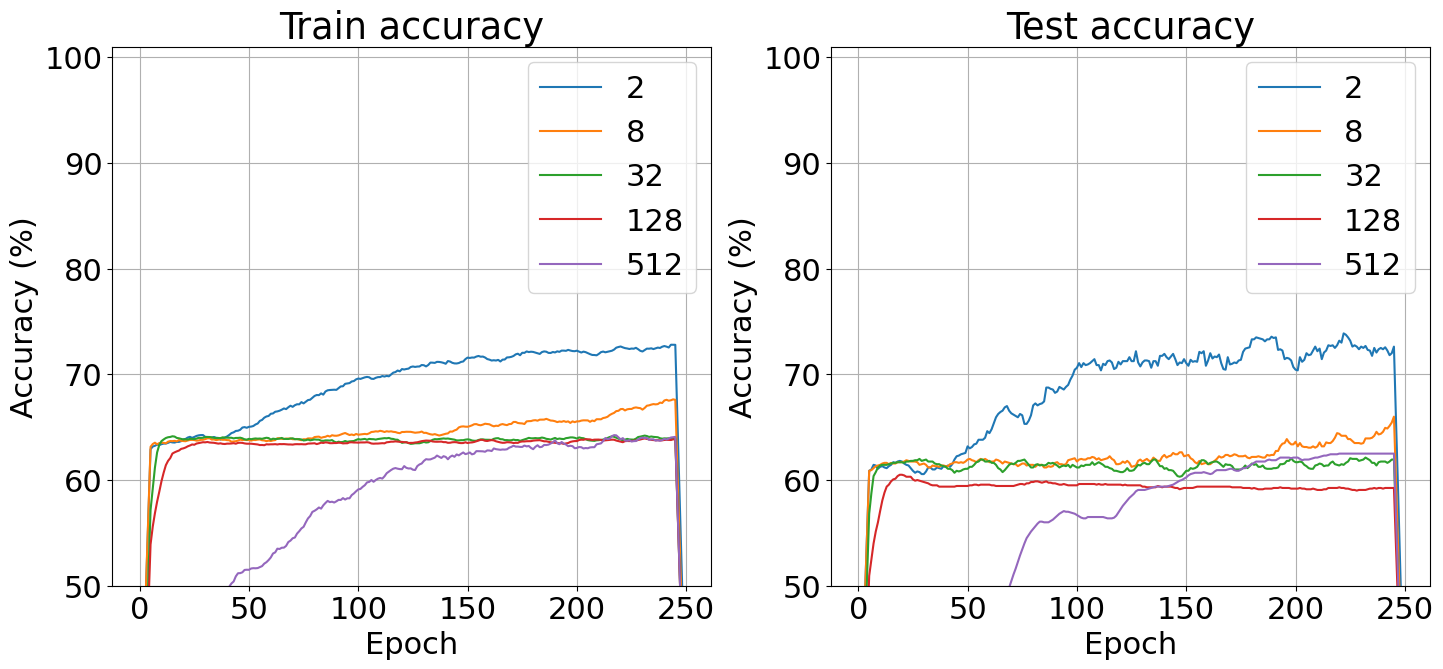

In [144]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = miniBatchSizes

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()